# VGGNet Implementation

**구현할 VGG Net 구조**  
![대체 텍스트](https://qph.fs.quoracdn.net/main-qimg-e657c195fc2696c7d5fc0b1e3682fde6)

**위의 과정에서 3번의 Convolution뒤에 아래 VGGNet의 Model을 참고하여 1 x 1 Convolution을 추가로 넣었다.**  

<img src="https://mblogthumb-phinf.pstatic.net/20160617_220/laonple_14661310924667hDhW_PNG/%C0%CC%B9%CC%C1%F6_6.png?type=w2" width="500" height="300">


## Prepare Data

- 모델이 학습이 되는지만 확인할 수 있게 간단한 데이터를 다운로드 합니다.

In [1]:
!rm -r images
import os 

# 이미지 파일을 저장할 폴더를 생성합니다.
try:
  os.mkdir("images")
  os.mkdir("images/dogs")
  os.mkdir("images/cats")
except:
  pass

# 이미지들을 지정한 위치에 다운로드합니다.
# images/dogs 밑에 2개
!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs

# images/cats 밑에 2개
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P images/cats

--2019-09-04 18:06:57--  https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.130.166, 151.101.2.166, 151.101.66.166, ...
Connecting to i.kinja-img.com (i.kinja-img.com)|151.101.130.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32099 (31K) [image/jpeg]
Saving to: ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’

ol9ceoqxidudap8owlw 100%[===================>]  31.35K  --.-KB/s    in 0.04s   

2019-09-04 18:06:58 (857 KB/s) - ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’ saved [32099/32099]

--2019-09-04 18:06:59--  https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg
Resolving www.rspcansw.org.au (www.rspcansw.org.au)... 101.0.77.122
Connecting to www.rspcansw.org.au (www.rspcansw.org.au)|101.0.77.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130940 (128K) [image/jpeg]

## 1. Settings
### 1) Import required libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

### 2) Hyperparameter

In [3]:
batch_size= 1
learning_rate = 0.0002
num_epoch = 100

## 2. Data Loader

- https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder
- ImageFolder라는 함수를 이용해 따로 이미지-라벨 쌍을 만들지 않고 폴더에 저장하는것만으로 쉽게 이미지-라벨 쌍을 만들 수 있습니다.

ex)

root/dog/xxx.png

root/dog/xxy.png

root/cat/123.png

root/cat/nsdf3.png

                    

**ImageFolder**  
torchvision.datasets.ImageFolder(root, transform=None, target_transform=None, loader=<function default_loader>, is_valid_file=None)  

**transform.Compose**  
torchvision.transforms.Compose(transforms)
- tranforms: list of Transform object

image Tranformation을 chained together할 수 있게 해준다.

**transform.Resize**  
torchvision.transforms.Resize(size, interpolation=2)
- size: 변경하고자 하는 image 크기
- interpolation: Desired interpolation. Default is PIL.Image.BILINEAR

Image 크기 변경.

**transform.RandomResizedCrop**  
torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
- size: 샘플링할 Image 크기
- scale: 원본 Image에서 자를 크기
- ratio: 원본 Image에서 자른 크기에서 참조할 비율
- interpolation – Default: PIL.Image.BILINEAR 

랜덤한 위치에서 샘플링.

**transform.RandomHorizontalFlip**  
torchvision.transforms.RandomHorizontalFlip(p=0.5)
- p: 확률

image 좌우 반전 시킬 확률

In [4]:
# 라벨(혹은 클래스) 별로 폴더가 저장되어 있는 루트 디렉토리를 지정합니다.
img_dir = "./images"

# 해당 루트 디렉토리를 ImageFolder 함수에 전달합니다.
# 이때 이미지들에 대한 변형도 같이 전달해줍니다.
img_data = dset.ImageFolder(img_dir, transforms.Compose([
                                      transforms.Resize(256),                   # 이미지 크기를 256x256으로 바꿔줍니다.
                                      transforms.RandomResizedCrop(224),        # 256x256 이미지의 랜덤한 위치에서 224x224 크기만큼 샘플링 합니다.
                                      transforms.RandomHorizontalFlip(),        # 랜덤한 확률로 이미지를 좌우반전 합니다.
                                      transforms.ToTensor(),                  # 이미지 데이터를 텐서로 변형합니다.
            ]))

train_loader = data.DataLoader(img_data, batch_size=batch_size,shuffle=True, num_workers=2)

실제 Sampling된 Image를 확인하기 위한 작업이다.  
train_loader를 불러와서 순서와 data, label을 불러와서 확인하였다.  
각 사진의 Title은 자동으로 할당된 Label의 이름이며  
data는 train_loader가 가지고 있는 image이다.

torch.Size([224, 224])
max: 0.9882352948188782, min: 0.007843137718737125


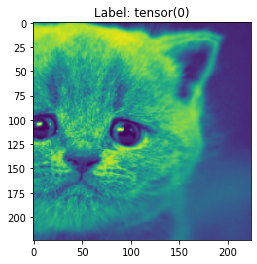

torch.Size([224, 224])
max: 0.9960784316062927, min: 0.0


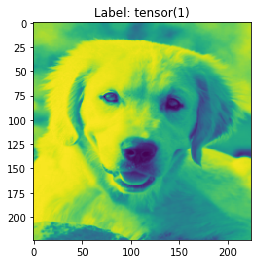

torch.Size([224, 224])
max: 0.9921568632125854, min: 0.08235294371843338


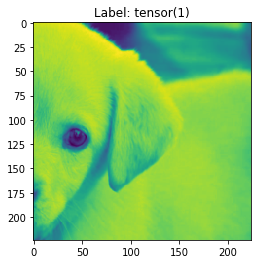

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
to_img = ToPILImage()

#j,[image,label] in enumerate(train_loader):
for i, [data,label] in enumerate(train_loader):
    img = data[0][0,:]
    print(img.size())
    print("max: {}, min: {}".format(np.max(img.numpy()), np.min(img.numpy())))
    str_title = 'Label: '+str(label[0])
    plt.title(str_title)
    plt.imshow(to_img(img))

    plt.show()

## 3. Model 
### 1) Basic Blocks

- 모델에 반복되는 부분이 많기 때문에 이를 함수로 만들어 단순화 한다.
- 맨 위에 이미지를 보면 컨볼루션 연산이 2번 연속하는 경우와 3번 연속하는 경우가 있는데 이를 각각 만들어줍니다.
- 3번 반복하는 Convolution연산인 경우 1 x 1 Convolution 추가


간단한 Output Filter Size를 측정하는 방법을 보게 되면  
- 입력 크기: (H, W)
- 필터 크기: (FH, FW)
- 출력 크기: (OH, OW)
- 패딩: P
- 스트라이드: S

<p>$$OH = \frac{H + 2P - FH}{S} + 1$$</p>
<p>$$OW = \frac{W + 2P - FW}{S} + 1$$</p>

위에서 Filter의 크기는 (3,3) 이므로 FH, FW 에 3을 대입하고 Stride에 1을 대입하게 되면  
Padding = 1로 해주어야지 Input 과 Output의 Size가 같다는 것을 알 수 있다.  
또한 위에서 Pooling 과정에서 Image의 Size가 1/2로 줄어들게 하기 위하여 Filter의 Size는 (2,2) Stride = 2로서 Size를 1/2로 줄인 것을 알 수 있다.

또한 실제 VGG처럼 구현하기 위하여 아래 코드를 추가하였다.  
        nn.Conv2d(out_dim,out_dim,kernel_size=1,padding=0),
        nn.ReLU(),  


**위의 코드의 의미는 1 x 1 Convolution을 사용하므로 개별 픽셀 하나이므로 특징 추출 효과는 거의 없지만 ReLU 활성 함수를 적용하므로 Non-Linearity가 추가되어 Model의 표현력이 더욱 강해진 것이 VGG의 핵심이다.**

In [6]:
# 컨볼루션 연산이 2번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

  
# 컨볼루션 연산이 3번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

### 2) VGG Model

In [7]:
# 위에서 정의한 블록들을 이용해 VGG 네트워크를 만들어보겠습니다.
# 필터의 개수가 2의 n승의 값을 가지기 때문에 base_dim이란 변수를 추가해서 단순화 했습니다.
# 현재 dog, cat 두 가지 클래스를 구분하려고 하기 때문에 num_classes=2로 설정했습니다.

class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=2):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim),
            conv_2_block(base_dim,2*base_dim),
            conv_3_block(2*base_dim,4*base_dim),
            conv_3_block(4*base_dim,8*base_dim),
            conv_3_block(8*base_dim,8*base_dim),            
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim * 7 * 7, 100),
            nn.ReLU(True),                                                      # True 는 inplace 연산을 하겠다는 의미를 가집니다. inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는것을 의미합니다.
            #nn.Dropout(),
            nn.Linear(100, 20),
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(20, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)                                               # x.size(0)를 batch size로 바꿔도 같은 값입니다.
        x = self.fc_layer(x)
        return x
    


## 4. Optimizer & Loss

**model.named_childern()**  


[docs]    def named_children(self):  
        r"""Returns an iterator over immediate children modules, yielding both
        the name of the module as well as the module itself.

        Yields:
            (string, Module): Tuple containing a name and child module

        Example::

            >>> for name, module in model.named_children():
            >>>     if name in ['conv4', 'conv5']:
            >>>         print(module)

        """

In [8]:
# gpu가 사용 가능한 경우에는 device를 0번 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 앞서 정의한대로 vGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = VGG(base_dim=16).to(device)

# 손실함수 및 최적화함수를 설정합니다.
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 자녀 노드의 이름과 모듈을 출력합니다.
for i in model.named_children():
    print(i)

cuda:0
('feature', Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel

## 5. Train

In [9]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 5 ==0:
        print(loss)

tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6628, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6200, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8916, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4562, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4168, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1045, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4014, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4286, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4268, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3774, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4161, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4936, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2596, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4774, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9926, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0181, device='cuda:0', grad_fn=<NllLossBackward